# GPT from scratch
## This notebook serves as a comprehensive guide to implement, code, and train a basic Generative Pretrained Transformer (GPT) model from scratch using Keras. It is based on the methodologies and code provided in “Generative Deep Learning, 2nd Edition” by David Foster (2023) (https://learning.oreilly.com/library/view/generative-deep-learning/9781098134174/ ) as well as the official Keras guides. The objective is to provide a hands-on approach to understanding and applying the principles of generative models, specifically focusing on the GPT model. This study aims to contribute to the broader understanding of generative deep learning and its applications.

## Context:
The goal here is to train a GPT model to generate beauty product reviews, a simple use case for such model would be to assess and evaluate the performance and popularity of a certain product or to enhance pre existing recommendation systems.

In [1]:
import pandas as pd
from tensorflow.keras import layers
%load_ext autoreload
%autoreload 2
import numpy as np
import json
import re
import string
from IPython.display import display, HTML
import tensorflow as tf
from tensorflow.keras import models, losses, callbacks

# Constants and model parameters
These are the hyperparameters for the model. VOCAB_SIZE is the size of the vocabulary, MAX_LEN is the maximum length of the sequences, EMBEDDING_DIM is the dimension of the word embeddings, KEY_DIM is the dimension of the keys in the attention mechanism, N_HEADS is the number of attention heads, FEED_FORWARD_DIM is the dimension of the feed-forward network in the transformer block, VALIDATION_SPLIT is the fraction of data to be used for validation, SEED is the random seed for reproducibility, LOAD_MODEL is a flag to load a pre-trained model, BATCH_SIZE is the size of the batches for training, and EPOCHS is the number of epochs for training.

In [28]:

VOCAB_SIZE = 5000
MAX_LEN = 1000
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 5

# About the data:

This dataset was collected via Python scraper in March 2023 and contains:
information about all beauty products (over 8,000) from the Sephora online store, including product and brand names, prices, ingredients, ratings, and all features.
user reviews (about 1 million on over 2,000 products) of all products from the Skincare category, including user appearances, and review ratings by other users

source : https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews

In [3]:
products = pd.read_csv('product_info.csv')
products.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [4]:
reviews = pd.read_csv('reviews_1250-end.csv')
reviews.head()

<ipython-input-4-073cac861190>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv('reviews_1250-end.csv')


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1945004256,5,1.0,0.000000,2,2,0,2022-12-10,I absolutely L-O-V-E this oil. I have acne pro...,A must have!,lightMedium,green,combination,NaN,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
1,1,5478482359,3,1.0,0.333333,3,2,1,2021-12-17,I gave this 3 stars because it give me tiny li...,it keeps oily skin under control,mediumTan,brown,oily,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
2,2,29002209922,5,1.0,1.000000,2,0,2,2021-06-07,Works well as soon as I wash my face and pat d...,Worth the money!,lightMedium,brown,dry,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
3,3,7391078463,5,1.0,1.000000,2,0,2,2021-05-21,"this oil helped with hydration and breakouts, ...",best face oil,lightMedium,brown,combination,blonde,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
4,4,1766313888,5,1.0,1.000000,13,0,13,2021-03-29,This is my first product review ever so that s...,Maskne miracle,mediumTan,brown,combination,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0


The product information and reviews are merged based on the product ID. Only the product name and review text are kept, and rows with missing values are dropped

In [5]:
text = pd.merge(left = products, right=reviews, on = 'product_id')[['product_name_x','review_text']].dropna()
text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49918 entries, 0 to 49976
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_name_x  49918 non-null  object
 1   review_text     49918 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [6]:
text.head()

,product_name_x,review_text
0,GENIUS Collagen Calming Relief,This product is amazing. Makes my skin feel so...
1,GENIUS Collagen Calming Relief,I pair this with the algae niacinamide moistur...
2,GENIUS Collagen Calming Relief,Definitely my favorite I use it for under eye ...
3,GENIUS Collagen Calming Relief,I bought this with the toner as I was looking ...
4,GENIUS Collagen Calming Relief,Been using for months now. I went in and asked...


The data is converted to JSON format, parsed, and then filtered to keep only the product review and the review text.

In [8]:
json_data = text.to_json(orient='records')
parsed_data = pd.read_json(json_data)
data = [
    'product review:' + row['product_name_x'] + ' | ' + row['review_text']
    for index, row in parsed_data.iterrows()
]


In [9]:
# Example of input data
data[0]

'product review:GENIUS Collagen Calming Relief | This product is amazing. Makes my skin feel so soft and hydrated and helps with any irritation I have.'

## Next the data is tokenized and vectorized using the TextVectorization layer from TensorFlow. The text is standardized to lowercase, the maximum number of tokens is set to 5000, the output mode is set to “int” to output integer indices, and the output sequence length is set to 201 (200 tokens for the input and 1 token for the output).

In [10]:
def format_string(s):
    s = re.sub(f"([{string.punctuation}])", r' \1 ', s)
    s = re.sub(' +', ' ', s)
    return s

text_data = [format_string(x) for x in data]
#Create a tf.data Dataset
text_dataset = tf.data.Dataset.from_tensor_slices(text_data).batch(32).shuffle(1000)

vectorize_layer = layers.TextVectorization(
    standardize = 'lower',
    max_tokens = 5000,
    output_mode = "int",
    output_sequence_length = 200 + 1,
)

vectorize_layer.adapt(text_dataset)
vocab = vectorize_layer.get_vocabulary()

### The inputs are prepared by tokenizing the sentences and creating the input and output sequences. The input sequence consists of all tokens except the last one, and the output sequence consists of all tokens except the first one.

In [11]:
def transform_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y

train_dataset = text_dataset.map(transform_inputs)

## To enhance efficiency during the training process, it would be ideal if the attention layer could process every word in the input simultaneously, making predictions about the next word for each. In simpler terms, we want our GPT model to be capable of managing multiple query vectors concurrently (i.e., in the form of a matrix). One might assume that we could simply group the vectors into a matrix and let linear algebra do the heavy lifting. While this is partially correct, there's an additional step required - we need to apply a mask to the dot product of the query/key to prevent future words from inadvertently revealing information. This process is referred to as causal masking

In [13]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## A Transformer block is an integral part of a Transformer model that incorporates skip connections, feed-forward layers, and normalization around the multihead attention layer. The query is circulated around the multihead attention layer and added to the output, forming a skip connection. This is a common feature in contemporary deep learning architectures, allowing the construction of deep neural networks that are less affected by the vanishing gradient problem. The skip connection acts as a gradient-free pathway, facilitating uninterrupted information transfer. Layer normalization is employed in the Transformer block to stabilize the training process. Unlike batch normalization, which normalizes the output from each channel to have a mean of 0 and standard deviation of 1 across the batch and spatial dimensions, layer normalization in a Transformer block normalizes each position of each sequence in the batch by calculating the normalizing statistics across the channels. This is the exact inverse of batch normalization in terms of how the normalization statistics are computed. Finally, the Transformer block includes a set of feed-forward (densely connected) layers. These layers enable the component to extract more complex features as the network delves deeper.

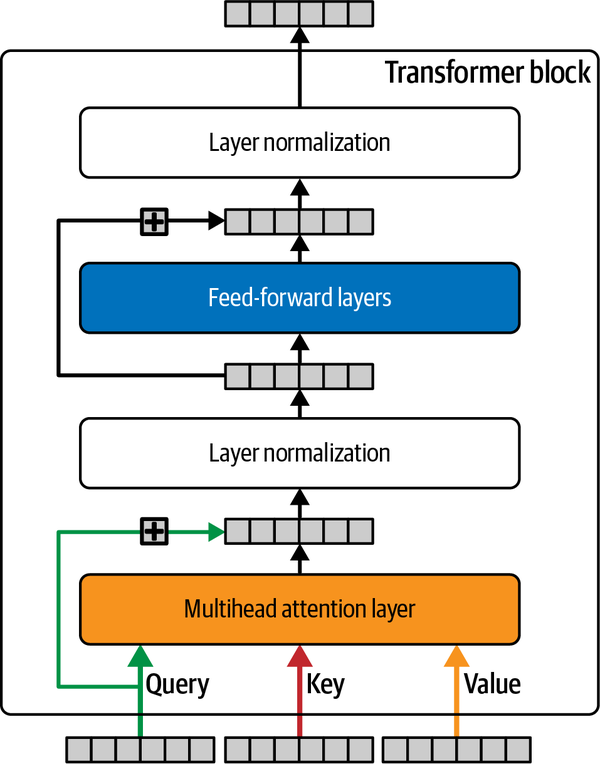

In [14]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

# Positional Encoding in GPT Model

Before we can proceed with training our GPT model, there’s a crucial step to address. You might have observed that the multihead attention layer doesn’t consider the sequence of the keys. The dot product between each key and the query is computed simultaneously, not sequentially as in a recurrent neural network. This parallel computation is advantageous due to efficiency gains, but it also presents a challenge. We need the attention layer to predict different outputs for different sentence contexts, such as:

The dog looked at the boy and …​ (barked?)

The boy looked at the dog and …​ (smiled?)

To overcome this issue, we employ a method known as positional encoding when generating the inputs for the initial Transformer block. Instead of merely encoding each token using a token embedding, we also encode the token’s position using a position embedding.

The token embedding is formed using a standard Embedding layer that transforms each token into a learned vector. Similarly, we can create the positional embedding using a standard Embedding layer that converts each integer position into a learned vector.

The joint token-position encoding is constructed by adding the token embedding to the positional embedding. This approach ensures that each word’s meaning and position in the sequence are encapsulated in a single vector.

In [15]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [16]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM
)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
gpt = models.Model(inputs=inputs, outputs=[outputs, attention_scores])
gpt.compile("adam", loss=[losses.SparseCategoricalCrossentropy(), None])

# The TextGenerator class is a callback that generates text at the end of each epoch during model training:


*   __init__(self, index_to_word, top_k=10): This method initializes the TextGenerator object. It creates a mapping from words to their corresponding indices (word_to_index) using the provided index_to_word dictionary.
*   sample_from(self, probs, temperature): This method takes in a probability distribution (probs) and a temperature parameter. It adjusts the probabilities using the temperature (higher values make the distribution more uniform, lower values make it more peaky) and then samples a token from this adjusted distribution.
* generate(self, start_prompt, max_tokens, temperature): This method generates a sequence of tokens. It starts with converting the start_prompt into a list of tokens. Then, in a loop that continues until the generated sequence is max_tokens long or a stop token (0) is produced, it does the following:
 * Feeds the current sequence of tokens into the model to get the probabilities of each possible next token.
 * Samples a token from these probabilities using the sample_from method.
Appends the sampled token to the sequence.
 * Adds the sampled token to the start_prompt string for the next iteration.
* on_epoch_end(self, epoch, logs=None): This method is automatically called at the end of each epoch during training. It calls the generate method to generate a text sequence starting with “recipe for”, with a maximum length of 100 tokens, and a temperature of 1.0.













In [29]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("product review:", max_tokens=100, temperature=1)

In [30]:
#Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [31]:
gpt.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, tensorboard_callback, text_generator],
)

Epoch 1/5
   5/1560 [..............................] - ETA: 1:19 - loss: 1.2952 - dense_2_loss: 1.2952

1559/1560 [============================>.] - ETA: 0s - loss: 1.1784 - dense_2_loss: 1.1784
generated text:
product review: un [UNK] dr . brandt [UNK] | this [UNK] cream that left me feel on [UNK] - the lift . the needle se [UNK] moisturizing winter & i had the [UNK] ( goals ) . 

1560/1560 [==============================] - 72s 46ms/step - loss: 1.1786 - dense_2_loss: 1.1786
Epoch 2/5
1559/1560 [============================>.] - ETA: 0s - loss: 1.1636 - dense_2_loss: 1.1636
generated text:
product review: : white moisturizing reset spray peptides + lip plumpfix | fan - to come out other lip balms i’ve tried and have used my lip white blemishes and my lips , maybe i’d give an itch constantly faced lip product that didn’t help with my lips lines . the smell is really good and moisturizing but it is nice as well as despite it is not that the issue ones do the job at home with what it might be . i used it so far and i’ll be using algenist products . it up smoothing and the

1560/1560 [====

In [26]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

# Examples :

In [51]:
info = text_generator.generate(
    "review for hyaluronic acid booster ", max_tokens=100, temperature=0.05
)


generated text:
review for hyaluronic acid booster  | this is a great moisturizer ! i have combination skin and i love how it feels on my skin . i use it as a primer and it doesn’t make my skin feel dry . i use it as a primer and it works great on my skin . i use it as a primer and it works great ! 



In [32]:
info = text_generator.generate(
    "review for hyaluronic acid booster ", max_tokens=100, temperature=0.5
)


generated text:
review for hyaluronic acid booster  | this is a great product . i have sensitive skin and this is the perfect size ! i have sensitive skin and this is the perfect amount of hydration and the texture is perfect . it absorbs quickly without leaving a residue . i love that it is vegan and cruelty free . 



In [53]:
info = text_generator.generate(
    "review for hyaluronic acid booster ", max_tokens=100, temperature=1
)


generated text:
review for hyaluronic acid booster  satisfying & hyaluronic acid deep moisture serum | i got this directly from rose hip seed oil ! naturally extremely hydrating and soothing skin . the texture of the scent , the smell is not bad . i have combo skin with those dry and sensitive skin that needs moisture , which is why i recommend using also great for sensitive skin types , most recommend it because a lotion . 



The temperature parameter in the generate method of the TextGenerator class controls the randomness of the text generation process. A lower temperature makes the output more deterministic, while a higher temperature makes it more diverse and random.

In the first and second example, with temperature=0.05 and 0.5, the generated text is more coherent and repetitive. The model tends to choose the most likely next word, leading to phrases like “this is the perfect size” and “this is the perfect amount of hydration” being repeated.

In the second example, with temperature=1, the generated text is more diverse and less predictable. The model is more likely to choose less probable words as the next word, leading to a more varied and creative output.

So, the temperature parameter allows you to control the trade-off between diversity and coherence in the generated text. A lower temperature leads to more predictable and coherent text, while a higher temperature leads to more diverse and creative text. However, too high a temperature might result in nonsensical text, and too low a temperature might result in overly repetitive text.

In [ ]:
print_probs(info, vocab)

### This is a basic guide on how to code a GPT model from scratch to generate reviews of beauty products. The code can be further improved and optimized based on the specific requirements of the task. For example, more sophisticated preprocessing and tokenization methods can be used, the model architecture can be modified, and different training strategies can be employed. The generated reviews can also be post-processed to ensure they meet certain criteria, such as length, coherence, and relevance to the product. The model can also be evaluated on a separate test set to assess its performance.

# Market Research with GPT Model
In this part we use our basic model to perform a basic market research on the popularity of a given product, but you may ask yourself what not just use the existing reviews ?
Well analyzing synthetic reviews generated by models like GPT has several advantages over analyzing only existing customer reviews:

* Volume and Diversity: Synthetic reviews can provide a large volume of data, which is especially useful when there are not enough real reviews available. This helps in understanding a wide range of potential customer opinions and experiences.
* Controlled Variables: When generating synthetic reviews, specific product features or customer profiles can be targeted, allowing for a more controlled study of particular aspects of consumer feedback, in our particular case this is not doable because we only used the product and its review but in the data we had far more context information we could have used to achieve this.
* Cost-Effective: Generating synthetic reviews is often less expensive than collecting a large number of real customer reviews, especially for new or hypothetical products.
* Risk Mitigation: For unreleased products, synthetic reviews can help predict customer reactions without the risk of negative publicity that could arise from real negative reviews.
* Ethical Considerations: Synthetic reviews eliminate the privacy concerns associated with analyzing real customer data, as they do not contain any personal information.
* Speed: Synthetic reviews can be generated quickly, enabling rapid analysis and decision-making.
* Testing Hypotheses: They allow companies to test out how changes in the product might affect customer satisfaction before actually making those changes.

In [58]:
product = 'Rose Quartz Facial Roller'.lower()

In [ ]:
synth_review = []
for _ in range(100):
  info = text_generator.generate(
    "review for"+product , max_tokens=100, temperature=0.5)
  synth_review.append(info[-1]['prompt'])

In [70]:
import random
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
def analyze_sentiment(reviews):
    sentiments = []
    for review in reviews:
        blob = TextBlob(review[len('review forrose quartz facial roller set |'):])
        sentiments.append(blob.sentiment.polarity)
    return sentiments

def aggregate_data(sentiments):
    sentiment_counts = Counter(sentiments)
    return sentiment_counts

def visualize_results(sentiments):
    plt.bar(sentiment_counts.keys(), sentiment_counts.values(), width = 0.1)
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

### TextBlob returns polarity and subjectivity of a sentence. Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment. So as you can see below most values are > 0 and a lot of them are > 0.5 which means most of the reception of this product is mostly positive

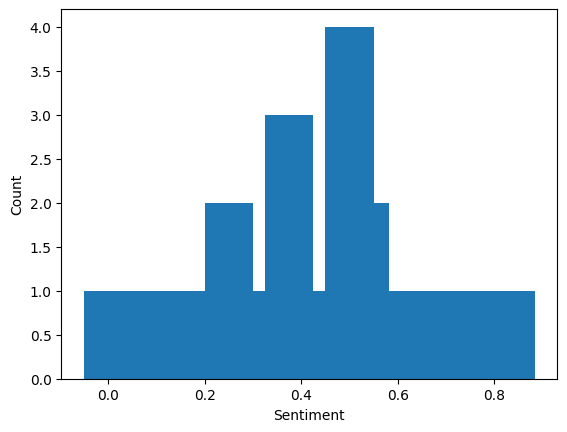

In [71]:
# Analyze sentiment
sentiments = analyze_sentiment(synth_review)

# Aggregate data
sentiment_counts = aggregate_data(sentiments)

# Visualize results
visualize_results(sentiment_counts)